## ハードマージンSVM

In [1]:
# Pythonの凸最適化ライブラリCVXPY
!pip install cvxpy

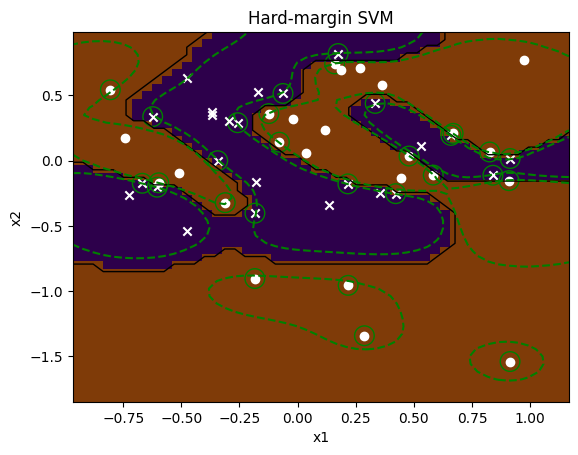

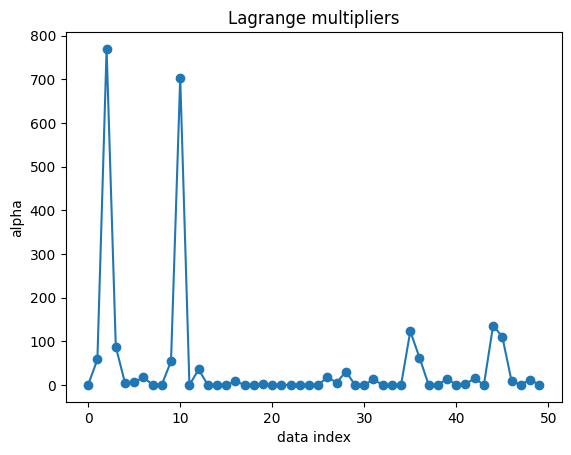

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, sqrt
import cvxpy as cp

# -1か１かを分類して返す。ハードマージンのSVM
def svm(x, x_train, y_train, alpha):
  L = x.shape[0] # 入力ベクトル数
  N = x_train.shape[0] # 訓練データ数
  y = np.zeros((L,))
  for ell in range(L):
    k = np.zeros((N,))
    for j in range(N):
      k[j] = exp(-10*((x[ell,:]-x_train[j,:])**2).sum()) # カーネル関数の計算。各グリッドとx_trainの関係を計算する
    y[ell] = alpha.value.T@(y_train*k) + b
  return 2*(y>0) - 1


def svm_decision(x, x_train, y_train, alpha, b):
  L = x.shape[0] # 入力ベクトル数
  N = x_train.shape[0] # 訓練データ数
  decision_values = np.zeros((L,))
  for ell in range(L):
    k = np.zeros((N,))
    for j in range(N):
      k[j] = exp(-10*((x[ell,:]-x_train[j,:])**2).sum()) # カーネル関数の計算。各グリッドとx_trainの関係を計算する
    decision_values[ell] = (alpha.value.T @ (y_train * k)) + b
  return decision_values


rng = np.random.default_rng(13)

# ラベルをランダムにつけたサンプルデータの生成
N = 50
beta = 1/0.5**2
x_train = (1./sqrt(beta))*rng.standard_normal((N,2))
y_train = 2*(rng.standard_normal((N,)) > 0) -1
marker = []
for n in range(len(y_train)):
  if y_train[n] == 1:
    marker.append('o')
  else:
    marker.append('x')

# RBFカーネル
K = np.zeros((N,N))
A = np.zeros((N,N))
for i in range(N):
  for j in range(N):
    K[i,j] = exp(-10*((x_train[i,:]-x_train[j,:])**2).sum()) # ハイパーパラメータを10とした
    A[i,j] = K[i,j]*y_train[i]*y_train[j]


# 双対問題の定義
alpha = cp.Variable(N)
objective = cp.Minimize((1/2)*cp.quad_form(alpha,A)-cp.sum(alpha)) # 目的関数L
constraints = [0 <= alpha,  alpha.T@y_train == 0] # 制約
prob = cp.Problem(objective, constraints) # 双対問題を定義

# 最適化の解
result = prob.solve(verbose = False) # 双対問題を解いた結果
b = (y_train - K@(alpha.value*y_train)).mean() # 最適化で得られたalphaを使って定数項bを計算


# サポートベクトルの特定
epsilon = 1e-4  # 非ゼロと見なすためのしきい値
support_vectors = np.where(alpha.value > epsilon)[0]


# グリッドの設定
xx, yy = np.meshgrid(np.linspace(1.2*x_train[:,0].min(), 1.2*x_train[:,0].max(), 50),
                    np.linspace(1.2*x_train[:,1].min(), 1.2*x_train[:,1].max(), 50))

Z = svm(np.vstack((xx.ravel(), yy.ravel())).T, x_train, y_train, alpha)
Z = Z.reshape(xx.shape)


# SVM決定関数の計算
X_grid = np.vstack((xx.ravel(), yy.ravel())).T
decision_values = svm_decision(X_grid, x_train, y_train, alpha, b)
decision_values = decision_values.reshape(xx.shape)


for n in range(len(y_train)):
  if n in support_vectors:
    plt.scatter(x_train[n, 0], x_train[n, 1], s=200, facecolors='none', edgecolors='green')  # サポートベクトルを緑の円で囲む
  plt.scatter(x_train[n, 0], x_train[n,1], marker=marker[n], color='white')

image = plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
countours = plt.contour(xx, yy, Z, levels=[0.5], linewidths=1, colors='k')

# 決定境界とマージンの描画
plt.contour(xx, yy, decision_values, levels=[-1,  1], colors='g', linestyles=['--', '--'])



plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Hard-margin SVM')
plt.show()



plt.plot(alpha.value, marker='o')
plt.title('Lagrange multipliers') # alphaが大きいピークが出てるところがサポートベクトルになっているところ。
plt.xlabel('data index')
plt.ylabel('alpha')
plt.show()



上図の緑のまるで囲まれたデータ点がサポートベクトルであり、緑の点線はマージン境界、黒い実線が分類境界である。サポートベクトルはマージン境界に位置しているのがわかる。これらのデータ点に関するalphaの値は下側の図で０でない値を取っている。

## ソフトマージンによる分類

2クラス分類問題を扱う。
二次元空間内の$\mathbf{x}$を3つのガウス分布から各40点ずつ生成した。

$c_1 = (-1,0), c_2 =(1,0), c_3=(0, \sqrt{3})$としてガウシアンは以下の通り。

$p_1(\mathbf{x}) = \mathcal{N}(\mathbf{x}|c_1, 0.25)$

$p_2(\mathbf{x}) = \mathcal{N}(\mathbf{x}|c_2, 0.25)$

$p_3(\mathbf{x}) = \mathcal{N}(\mathbf{x}|c_3, 0.25)$

$p_1(\mathbf{x})$から生成された$\mathbf{x}$にはラベル$y=0$

$p_2(\mathbf{x}),p_3(\mathbf{x})$から生成された$\mathbf{x}$にはラベル$y=1$

を対応させる。

これらのデータをソフトマージンSVMを用いて分類する。

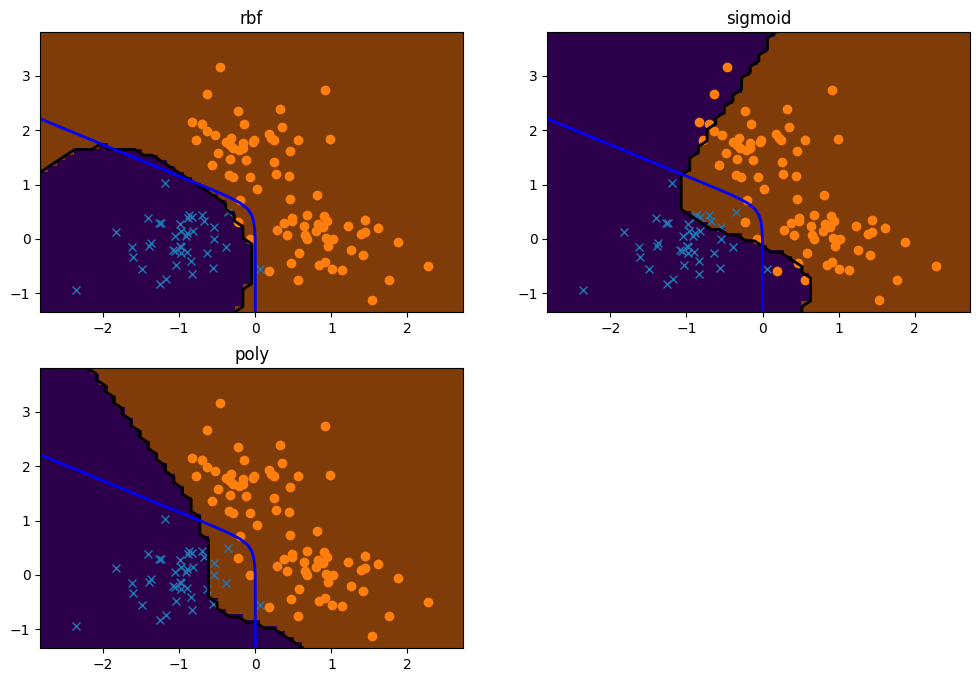

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, sqrt

from sklearn.svm import SVC #sklearnからSVCをとってきた

# 確率p(y=1|x)を与える関数の定義
def prob_true(x):
  a =  exp(-beta/2*np.linalg.norm(x-c1, axis=1)**2)
  b =  exp(-beta/2*np.linalg.norm(x-c2, axis=1)**2)
  c =  exp(-beta/2*np.linalg.norm(x-c3, axis=1)**2)
  return (b+c)/(a+b+c)

# 乱数の初期化
rng = np.random.default_rng(1)


# サンプルデータの生成

beta = 1/0.5 ** 2 # betaは精度。標準偏差は0.5
N = 120 # データの数
c1 = np.atleast_2d(np.array([-1,0]))
c2 = np.atleast_2d(np.array([1,0]))
c3 = np.atleast_2d(np.array([0, sqrt(3)]))

x_train = (1./sqrt(beta)) * rng.standard_normal((N,2)) # 標準偏差1/sqrt(beta)のガウス分布ガウンに従う二次元での点をN個生成。N*2の形でデータを持っている

x_train[:int(N/3), :] += c1 # データのうち最初の1/3はc1周りに散らす
x_train[int(N/3):int(2*N/3), :] += c2
x_train[int(2*N/3):, :] += c3

# 正解ラベルを付ける
y_train = np.zeros(N) # 全部0で初期化
y_train[int(N/3):] = 1 # 後半2/3は正解ラベル１にする
y_train = (y_train > 0.5) # 数値だったものをTrue/Falseに変換した



# 図のサイズ
plt.figure(figsize = (12,8))

# カーネルをいろいろ変えて分類してみる（三種類試している。ガウシアン、シグモイド、poly多項式３次関数）
kernel_list = ['rbf', 'sigmoid', 'poly']
indx = 1 #絵を描くときのindex
degree = 3 # 多項式カーネルの次数
for kernel in kernel_list:
    # SVCでのフィッティング
    clf = SVC(C=1, gamma = 'scale', kernel = kernel_list[indx-1], degree = degree).fit(x_train, y_train) #一行で書いてfitまでしてしまっている

    # グリッドの設定
    xx, yy = np.meshgrid(np.linspace(1.2*x_train[:,0].min(), 1.2*x_train[:,0].max(), 50),
                         np.linspace(1.2*x_train[:,1].min(), 1.2*x_train[:,1].max(), 50))

    # 真の判別確率
    Z_true = prob_true(np.vstack((xx.ravel(), yy.ravel())).T)
    Z_true = Z_true.reshape(xx.shape)
    # モデルの判別確率
    Z = clf.predict(np.vstack((xx.ravel(), yy.ravel())).T)
    Z = Z.reshape(xx.shape)

    # 判別確率と決定境界の図示
    plt.subplot(2,2,indx)
    plt.plot(x_train[:int(N/3),0], x_train[:int(N/3),1], 'x') # y=0のデータ点
    plt.plot(x_train[int(N/3):,0], x_train[int(N/3):,1], 'o') # y=1のデータ点
    plt.title(kernel_list[indx-1])
    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors=['k'])
    contours2 = plt.contour(xx, yy, Z_true, levels=[ 0.5], linewidths=2, linestyles = '-', colors=['b'])
    indx +=1

plt.show()



上図で青の実線が本来の分類境界。黒の実線が、各カーネルをもちいてソフトマージンＳＶＭを行ったときの分類境界である。

## ソフトマージンSVMでハイパーパラメータの選択

RBFカーネルを採用する

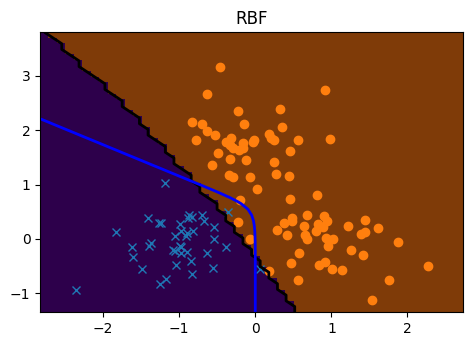

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, sqrt

from sklearn.svm import SVC #sklearnからSVCをとってきた
from sklearn.model_selection import cross_validate

# 確率p(y=1|x)を与える関数の定義
def prob_true(x):
  a =  exp(-beta/2*np.linalg.norm(x-c1, axis=1)**2)
  b =  exp(-beta/2*np.linalg.norm(x-c2, axis=1)**2)
  c =  exp(-beta/2*np.linalg.norm(x-c3, axis=1)**2)
  return (b+c)/(a+b+c)

# 乱数の初期化
rng = np.random.default_rng(1)


# サンプルデータの生成

beta = 1/0.5 ** 2 # betaは精度。標準偏差は0.5
N = 120 # データの数
c1 = np.atleast_2d(np.array([-1,0]))
c2 = np.atleast_2d(np.array([1,0]))
c3 = np.atleast_2d(np.array([0, sqrt(3)]))

x_train = (1./sqrt(beta)) * rng.standard_normal((N,2)) # 標準偏差1/sqrt(beta)のガウス分布ガウンに従う二次元での点をN個生成。N*2の形でデータを持っている

x_train[:int(N/3), :] += c1 # データのうち最初の1/3はc1周りに散らす
x_train[int(N/3):int(2*N/3), :] += c2
x_train[int(2*N/3):, :] += c3

# 正解ラベルを付ける
y_train = np.zeros(N) # 全部0で初期化
y_train[int(N/3):] = 1 # 後半2/3は正解ラベル１にする
y_train = (y_train > 0.5) # 数値だったものをTrue/Falseに変換した




# ハイパーパラメータの候補値
C_cand = [0.001, 0.01, 0.1, 1, 10, 100] # C の候補値
gam_cand =  [0.001, 0.01, 0.1, 1, 10, 100] # カーネル幅gamma の候補値

# 分類実験を100 回行う
NEXP = 5
C_list = []
gam_list =[]
CV_list = []

for nexp in range(NEXP):
  # グリッドサーチ
  C_best = C_cand[0]
  gam_best = gam_cand[0]
  CV_best = 0
  for C in C_cand:
    for gam in gam_cand:
      clf = SVC(C=C, gamma=gam, kernel='rbf', degree=degree)
      cv_result = cross_validate(clf, x_train, y_train, cv=10)
      if CV_best < cv_result['test_score'].mean():
        C_best = C
        gam_best = gam
        CV_best = cv_result['test_score'].mean()
  C_list.append(C_best)
  gam_list.append(gam_best)
  CV_list.append(CV_best)





# 図のサイズ
plt.figure(figsize = (12,8))

# SVCでのフィッティング
clf = SVC(C=np.mean(C_list), gamma = np.mean(gam_list), kernel = 'rbf', degree = degree).fit(x_train, y_train) # 一行で書いてfitまでしてしまっている

# グリッドの設定
xx, yy = np.meshgrid(np.linspace(1.2*x_train[:,0].min(), 1.2*x_train[:,0].max(), 50),
                      np.linspace(1.2*x_train[:,1].min(), 1.2*x_train[:,1].max(), 50))

# 真の判別確率
Z_true = prob_true(np.vstack((xx.ravel(), yy.ravel())).T)
Z_true = Z_true.reshape(xx.shape)
# モデルの判別確率
Z = clf.predict(np.vstack((xx.ravel(), yy.ravel())).T)
Z = Z.reshape(xx.shape)

# 判別確率と決定境界の図示
plt.subplot(2,2,indx)
plt.plot(x_train[:int(N/3),0], x_train[:int(N/3),1], 'x') # y=0のデータ点
plt.plot(x_train[int(N/3):,0], x_train[int(N/3):,1], 'o') # y=1のデータ点
plt.title('RBF')
image = plt.imshow(Z, interpolation='nearest',
                    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                    aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
contours = plt.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors=['k'])
contours2 = plt.contour(xx, yy, Z_true, levels=[ 0.5], linewidths=2, linestyles = '-', colors=['b'])

plt.show()




In [34]:
print(C_list)
print(np.mean(C_list))
print(gam_list)
print(np.mean(gam_list))

[10, 10, 10, 10, 10]
10.0
[0.01, 0.01, 0.01, 0.01, 0.01]
0.01


ハイパーパラメータとして$C=10.0$、$\gamma=0.01$がよいことが交差検証法によって分かった。
今回はKは５として、５つのグループに分け、４セットを訓練データとして使い、残りの１セットを誤差を評価した。これを５回繰り返し、その平均の誤差を検証誤差とした。

## SVMを用いたアヤメデータの分類

アヤメは
 - Iris-Setosa
 - Iris-Versicolour
 - Iris-Virginica

に分類される。これを
 - がくの長さ (Sepal Length)
 - がくの幅 (Sepal Width)
 - 花びらの長さ (Petal Length)
 - 花びらの幅 (Petal Width)

の４つの特徴量にもとづいて行う。
３種類のアヤメ、それぞれに対して50個、計150個のラベル付きデータから構成されている。

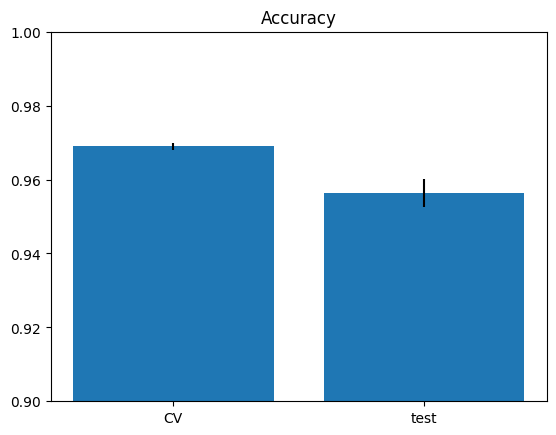

In [36]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

rng= np.random.default_rng(1)

iris = load_iris() # アヤメデータの読み込み
scaler = StandardScaler().fit(iris.data) # 特徴量を読み込み、正規化の準備をする
X = scaler.transform(iris.data)
y = iris.target # クラスラベル0,1,2の３クラス

# ハイパーパラメータの候補値
C_cand = [0.001, 0.01, 0.1, 1, 10, 100] # C の候補値
gam_cand =  [0.001, 0.01, 0.1, 1, 10, 100] # カーネル幅gamma の候補値

# 分類実験を100 回行う
NEXP = 100
C_list = []
gam_list =[]
CV_list = []
test_list =[]

for nexp in range(NEXP):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) # 訓練データとテストデータの分割

    # グリッドサーチ
    C_best = C_cand[0]
    gam_best = gam_cand[0]
    CV_best = 0
    for C in C_cand:
        for gam in gam_cand:
            clf = SVC(kernel = 'rbf', C = C, gamma = gam)
            cv_result = cross_validate(clf, X_train, y_train, cv = 10)
            if CV_best < cv_result['test_score'].mean():
                C_best = C
                gam_best = gam
                CV_best = cv_result['test_score'].mean()

    # 最良のC, gam，その際に得られているCV正答率を記録
    C_list.append(C_best)
    gam_list.append(gam_best)
    CV_list.append(CV_best)

    # テストデータに対する正答率を評価
    clf = SVC(C = C_best, gamma = gam_best).fit(X_train, y_train)
    Accuracy_test = (y_test == clf.predict(X_test)).mean()
    test_list.append(Accuracy_test)


# 結果の出力
label = ['CV', 'test']
height = [np.mean(CV_list), np.mean(test_list)]
yerr = [np.std(CV_list)/np.sqrt(NEXP), np.std(test_list)/np.sqrt(NEXP)]
plt.bar([0,1], height, tick_label = label, yerr = yerr, ecolor = 'black')
plt.title('Accuracy')
plt.ylim(0.9, 1.0)
plt.show()



In [41]:
print(f'CV Accuracy = {np.mean(CV_list):.4f}, error {np.std(CV_list)/np.sqrt(NEXP):.4f}')
print(f'Test Accuracy = {np.mean(test_list):.4f}, error {np.std(test_list)/np.sqrt(NEXP):.4f}')

CV Accuracy = 0.9690, error 0.0009
Test Accuracy = 0.9563, error 0.0038


In [42]:
print(C_list)
print(gam_list)

[10, 10, 100, 10, 10, 10, 10, 1, 10, 10, 1, 10, 10, 10, 10, 1, 100, 10, 100, 10, 1, 100, 10, 10, 10, 10, 100, 10, 10, 1, 10, 100, 10, 10, 1, 10, 1, 100, 10, 10, 10, 100, 1, 1, 100, 1, 100, 1, 10, 1, 10, 1, 1, 1, 10, 10, 10, 10, 0.1, 10, 100, 1, 10, 10, 10, 1, 10, 10, 10, 100, 10, 1, 100, 10, 10, 10, 100, 10, 100, 100, 1, 10, 10, 1, 10, 10, 1, 100, 10, 1, 10, 100, 10, 1, 1, 1, 10, 10, 100, 1]
[0.01, 0.1, 0.01, 0.1, 0.1, 0.01, 0.01, 0.1, 0.1, 0.01, 1, 0.01, 0.01, 0.01, 0.01, 1, 0.001, 0.01, 0.01, 0.01, 0.1, 0.001, 0.01, 0.01, 0.01, 0.1, 0.01, 0.1, 0.01, 0.1, 0.01, 0.01, 0.1, 0.01, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.001, 0.1, 0.01, 0.1, 0.01, 1, 0.01, 0.1, 0.1, 0.1, 0.01, 0.1, 0.01, 0.1, 1, 0.1, 0.01, 0.1, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 0.001, 0.01, 0.1, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.001, 0.1, 0.1, 0.01, 0.1, 0.1, 0.01, 0.1, 0.001, 0.1, 0.1, 0.01, 0.01, 0.01, 0.1, 1, 0.1, 0.01, 0.01, 0.1, 0.1]
